<a href="https://colab.research.google.com/github/Burningzabidan/kims/blob/main/%5B%E1%84%87%E1%85%A6%E1%84%8B%E1%85%A5%E1%84%85%E1%85%B5%E1%86%BC%E1%84%80%E1%85%AA%E1%84%8C%E1%85%A6%5D%E1%84%80%E1%85%A1%E1%86%BC%E1%84%83%E1%85%A9_%E1%84%8B%E1%85%A8%E1%84%8E%E1%85%B3%E1%86%A8_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models

import os
import cv2
from PIL import Image
import re
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

#1. 인장 시험 데이터 가져오기 및 전처리

In [12]:
def pre_proc(file_dir:str) -> pd.DataFrame:
    """
    인장 시험 파일 불러오기
    불필요한 문자 삭제
    파일 df화
    """
    # load tensile test result
    f = open(file_dir,"r")
    lines = f.readlines()
    new_lines = []

    # \n, 공백 삭제
    for line in lines:
      new_lines.append(re.sub('[\n| ]', '', line))

    # df로 만들기
    new_lines_np = np.array(new_lines).reshape(-1,6)
    tensile_res = [[] for _ in range(4)]
    for i in range(len(new_lines_np)):
      for j in new_lines_np[i]:
        if re.match('[가-힣]',j):
          if tensile_res[i%4] == []:
            tensile_res[i%4].append(j)
        else:
          tensile_res[i%4].append(j)

    tensile_res = np.array(tensile_res).reshape(4,-1)
    df_tensile_res = pd.DataFrame(tensile_res[1:,1:], index = tensile_res[1:,0])
    df_tensile_res.columns = tensile_res[0,1:]
    df_tensile_res
    return df_tensile_res

df_tensile_res = pre_proc("/content/tensile_test_result.txt")
# check the result
df_tensile_res

,1-1,1-2,1-3,1-4,1-5,2-1,2-2,2-3,2-4,2-5,...,4-1,4-2,4-3,4-4,4-5,5-1,5-2,5-3,5-4,5-5
인장강도N/mm2,1527,1439,1445,1421,1429,1200,1225,1256,1211,1253,...,1004,1004,1033,1019,994,896,882,918,897,928
항복강도(0.2%offset)N/mm2,1454,1359,1381,1354,1369,1113,1128,1186,1117,1170,...,907,902,927,916,896,816,780,826,831,845
연신율(GL:50mm)%,11,13,12,13,13,14,14,14,15,15,...,19,18,16,18,19,21,21,21,21,20


In [97]:
def get_linked_prop(df:pd.DataFrame) -> dict:
  """
  df로 정리된 인장 시험 결과를 샘플 시리즈를 keyword로,
  물성 별 측정값을 value로 갖는 딕셔너리를 반환함
  """
  # 빈 연결 리스트 생성
  properties = {}
  for i in range(1,6):
    properties[i] = {}
    for j in ("TS", "YS", "EL"):
      properties[i][j] = []

  # df로부터 시리즈별 물성을 연결 리스트에 저장
  for m in df_tensile_res.columns:
    for k,l in enumerate(["TS", "YS", "EL"]):
      p = int(df_tensile_res[m][k])
      properties[int(m[0])][l].append(p)
  return properties

properties = get_linked_prop(df_tensile_res)
# check the result
print(f"sample series:{list(properties.keys())}")
print(f"properties of each series:{list(properties[1].keys())}")
len_TS = len(properties[1]["TS"])
print(f"number of TS data:{len_TS}")

sample series:[1, 2, 3, 4, 5]
properties of each series:['TS', 'YS', 'EL']
number of TS data:5


#2. 이미지 데이터 가져오기 및 전처리

number of sample series:5
number of sample subseries:280
size of images:(224, 224, 3)


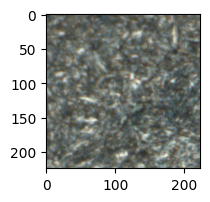

In [121]:
### 연결 리스트로 샘플 시리즈별 이미지 정리

def get_lined_img(files_dir:str) -> dict:
  """
  이미지를 불러와서 샘플 시리즈를 keyword,
  이미지를 value로 갖는 딕셔너리를 반환함
  """
  # 빈 연결 리스트 생성
  imgs = {}
  for i in range(1,6):
    imgs[i] = []

  # 이미지를 크롭(224x224x3)하여 시리즈별로 연결 리스트에 저장
  files = [f for f in os.listdir(files_dir) if "tif" in f]
  for file in files:
    img = cv2.imread(file)/255
    h,w,c = img.shape
    for dx in range(0,h-224,112):
      for dy in range(0,w-224,112):
        img_crop = img[dx:dx+224,dy:dy+224]
        series = int(file[0])
        imgs[series].append(img_crop)

  return imgs

imgs = get_lined_img("./")

# check the result
print(f"number of sample series:{len(imgs)}")
print(f"number of sample subseries:{len(imgs[1])}")
print(f"size of images:{imgs[1][0].shape}")

# plot example
plt.figure(figsize = (2,2))
plt.imshow(imgs[1][0])

# 3. 이미지 별 물성 생성


In [187]:
### 연결 리스트로 생성된 물성 저장

def alloc_prop(imgs:dict, properties:dict) -> dict:
  """
  이미지가 해당 시리즈의 물성의 최대 최소 값 사이의 값을 가지도록
  물성 값을 랜덤하게 생성후 할당
  """
  # 빈 연결 리스트 생성
  props = {}
  for i in range(1,6):
    props[i] = {}
    for j in ("TS", "YS", "EL"):
      props[i][j] = []

  # 난수 시드 고정
  np.random.seed(0)

  # 생선된 물성 (propserated) 연결 리스트에 저장
  for i in range(1,6):
    for j in ("TS", "YS", "EL"):
      n_min = min(properties[i][j])
      n_max = max(properties[i][j])
      n_imgs = len(imgs[i])
      for _ in range(n_imgs):
        prop_gen = random.choice(range(n_min, n_max+1))
        props[i][j].append(prop_gen)
  return props

props = alloc_prop(imgs,properties)

# check the result
print(f"number of sample series:{list(props.keys())}")
print(f"number of properties:{list(props[1].keys())}")
num_data = [len(props[i]["TS"]) for i in props]
print(f"number of data:{sum(num_data), num_data}")

number of sample series:[1, 2, 3, 4, 5]
number of properties:['TS', 'YS', 'EL']
number of data:(1540, [280, 350, 350, 350, 210])


In [202]:
def stack_props(target:str, properties:dict) -> np.array:
  res = []
  for i in props:
    res.extend(props[i][target])
  return np.array(res)

y_ = stack_props("TS", props)
print(len(y_))

1540


In [205]:
def stack_imgs(imgs:dict) -> np.array:
  # 이미지 총 갯수 구하기
  n = sum([len(imgs[i]) for i in imgs])
  # 이미지 차원 구하기
  h,w,c = imgs[1][0].shape # 1번째 시리즈의 1번째 이미지
  # 빈 이미지 변수 생성 -> 미리 만들어주는게 효율적
  imgs_stack = np.empty((n,h,w,c))

  # 이미지 쌓기
  idx = 0
  for i in imgs:
    for img in imgs[i]:
      imgs_stack[idx] = img
      idx += 1
  return imgs_stack

X = stack_imgs(imgs)
print(len(X))

1540


#2. 모델링

In [ ]:
# loading resnet101
my_model = models.resnet101(pretrained = True)

# change in and out features of fc layer
in_features = my_model.fc.in_features
out_features = 1
my_model.fc = nn.Linear(in_features, out_features)

# freeze parameters when training
for params in my_model.parameters():
  params.requires_grad = False

# unfreeze parameters of fc layer when training
for params in my_model.fc.parameters():
  params.requires_grad = True

# model to device
device = "cuda" if torch.cuda.is_available() else "cpu"
my_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#3. 모델 훈련

In [ ]:
# 이미지 정규화
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225],
    )]
)



out = my_model(inp)
lr = 0.0001 # learning rate
optimizer = torch.optim.Adam(my_model.parameters(), lr=lr)
loss_fn = nn.MSELoss().to(device)

In [2]:
a:int = "3"

In [5]:
a

'3'